## Chapter 21 - Dichotomous Predicted Variable

- [21.1 - Multiple Metric Predictors](#21.1---Multiple-Metric-Predictors)
- [21.3 - Robust Logistic Regression](#21.3---Robust-Logistic-Regression)
- [21.4 - Nominal Predictors](#21.4---Nominal-Predictors)

In [62]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc
import theano.tensor as tt

from scipy.stats import norm, mode
from scipy.special import expit
from matplotlib import gridspec
from IPython.display import Image
from sklearn import preprocessing

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

In [2]:
# Below function takes an array as input.

def plot_posterior(dist, decimals=3, vert_ref=None, alpha=0.05, point_est='mode', burnin=0, y_labels=False, ax=None):
       
    color = '#87ceeb'
    font_d = {'size':14}
    
    if ax == None:
        ax = plt.gca()
               
    hpd_interval = np.round(pmc.hpd(dist[burnin:], alpha=alpha), decimals=decimals)
        
    # Histogram, Mode/Mean
    sns.distplot(dist[burnin:], kde=False, color=color, ax=ax)
    plot_height = ax.get_ylim()[1]
    
    if point_est == 'mode':
        p_est_value = mode(np.round(dist[burnin:], decimals=decimals))[0][0]
    else:
        p_est_value = np.round(np.mean(dist[burnin:]), decimals=decimals)
    
    ax.text(p_est_value, plot_height*.9, '{} = {}'.format(point_est, p_est_value),
            horizontalalignment='center', fontdict=font_d, clip_on=False)    

    # HPD interval
    ax.hlines(ax.get_ylim()[1]*0.01, *hpd_interval, linewidth=4)
    for interval_point in hpd_interval:
        ax.text(interval_point, plot_height*0.05, interval_point,
                horizontalalignment='center', fontdict=font_d)
    ax.text(np.mean(hpd_interval), plot_height*0.13, '{}% HPD'.format((1-alpha)*100),
            horizontalalignment='center', fontdict=font_d)

    # Reference line
    if vert_ref is None:
        ax.axvline(p_est_value, color='g', linestyle='dotted')
    else:
        ax.axvline(vert_ref, color='g', linestyle='dotted')

    # Set labels and axis
    if y_labels is False:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)
    [ax.spines[spine].set_visible(False) for spine in ['right', 'top']]
    
    return(ax)

### 21.1 - Multiple Metric Predictors

#### Data

In [21]:
df = pd.read_csv('data/HtWtData110.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
male      110 non-null int64
height    110 non-null float64
weight    110 non-null float64
dtypes: float64(2), int64(1)
memory usage: 2.7 KB


In [22]:
X = df[['height', 'weight']]
y = df['male']

meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

#### Model (Kruschke, 2015)

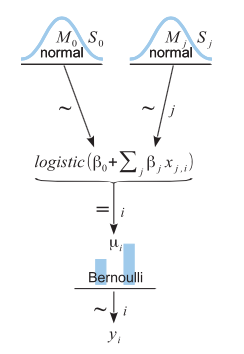

In [5]:
Image('images/fig21_2.png')

#### Predicting gender from weight alone

In [23]:
with pmc.Model() as model_weight:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=2)
        
    p = pmc.invlogit(zbeta0 + zbetaj*zX[:,1])
        
    likelihood = pmc.Bernoulli('likelihood', p, observed=y.values)

In [24]:
with model_weight:
    trace1 = pmc.sample(20000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
 [-----------------100%-----------------] 20000 of 20000 complete in 7.8 sec

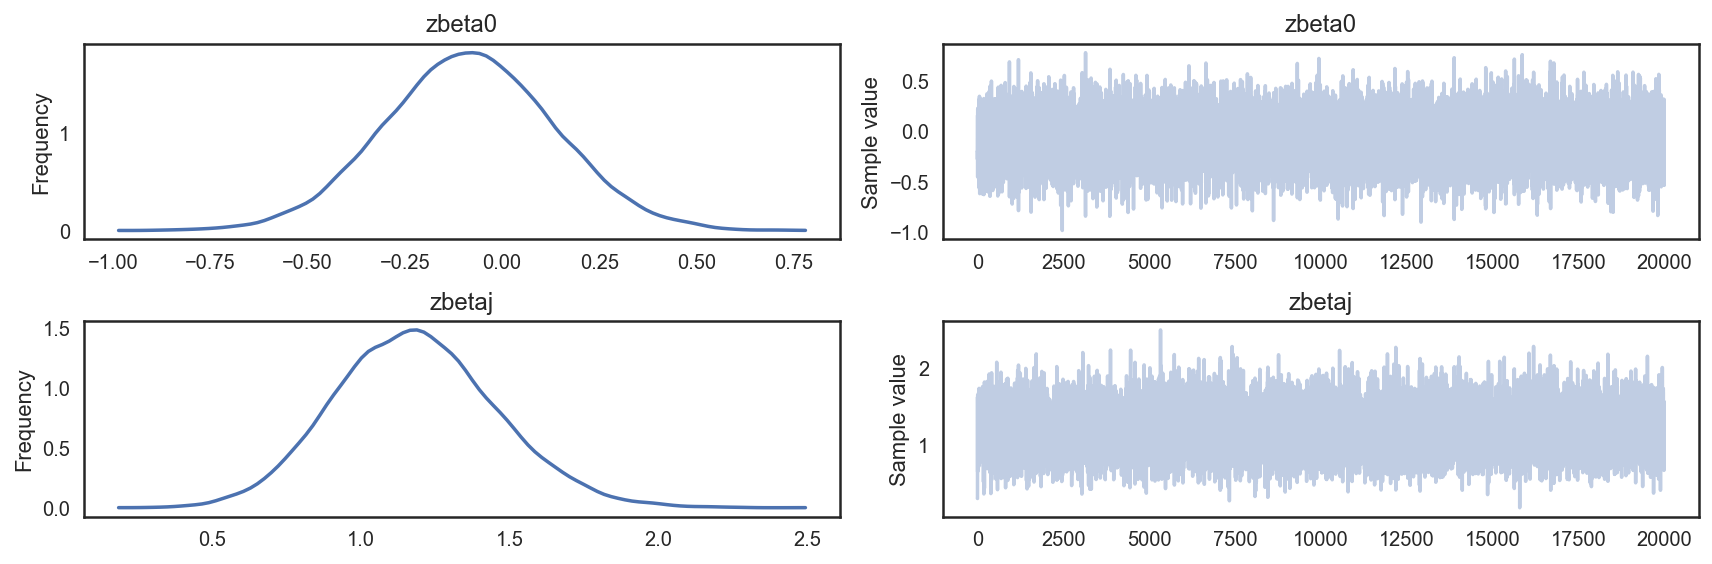

In [25]:
pmc.traceplot(trace1);

#### Figure 21.3

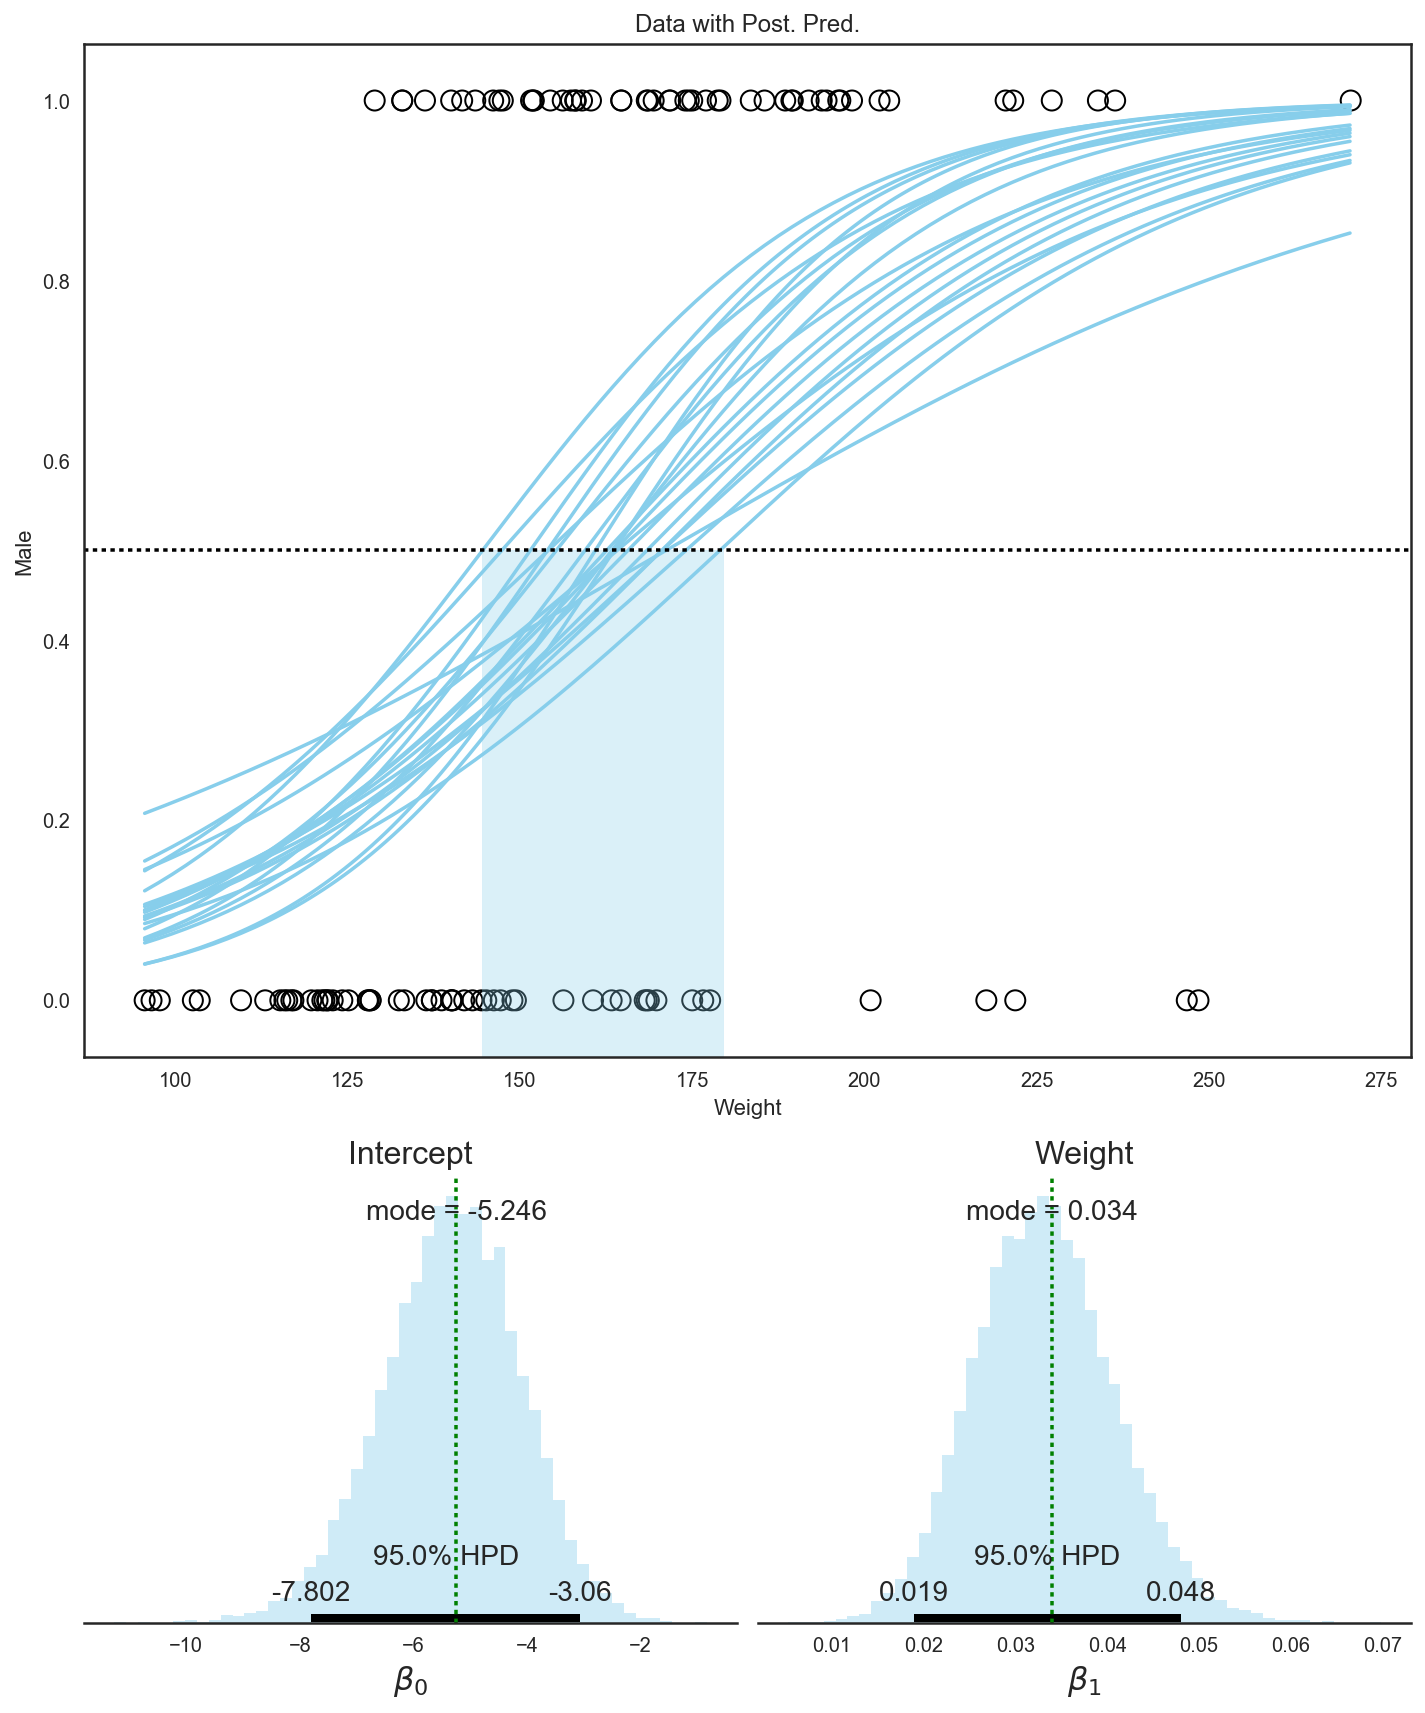

In [26]:
# Transform parameters back to original scale
beta0 = trace1['zbeta0'] - trace1['zbetaj']*meanx[1]/scalex[1]
betaj = (trace1['zbetaj']/scalex[1])

plt.figure(figsize=(10,12))
# Define gridspec
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[:2,:4])
ax2 = plt.subplot(gs[2,:2])
ax3 = plt.subplot(gs[2,2:])

ax1.scatter(df.weight, df.male, s=100, edgecolor='k', facecolors='None', lw=1)

# Take 20 values from the posterior distribution and plot the lines
n_curves = 20
tr_len = len(trace1)
stepIdxVec = np.arange(500, tr_len, tr_len//n_curves)
weight_span = np.arange(df.weight.min(), df.weight.max())
weights = np.tile(weight_span.reshape(-1,1), (1,n_curves))
# The expit function from scipy.special calculates the inverse of the logit function
p = expit(beta0[stepIdxVec] + betaj[stepIdxVec]*weights)
ax1.plot(weights, p, c=color)

ax1.axhline(y=0.5, color='k', linestyle='dotted')

# Look up weights for which of the posterior probabilities is (close to) 0.5
decision_boundary = weight_span[np.any(np.isclose(p, 0.5, atol=0.01), axis=1)]
# Highlight the weightspan
ax1.axvspan(decision_boundary.min(), decision_boundary.max(),
            0, 0.5, color=color, alpha=0.3)

ax1.set_xlabel('Weight')
ax1.set_ylabel('Male')
ax1.set_title('Data with Post. Pred.')

plot_posterior(beta0, ax=ax2)
ax2.set_title('Intercept', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)

plot_posterior(betaj, ax=ax3)
ax3.set_title('Weight', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict);

plt.tight_layout();

#### Predicting gender from weight and height

In [10]:
with pmc.Model() as model:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=2, shape=(2))
        
    p = pmc.invlogit(zbeta0 + pmc.dot(zbetaj, zX.T))
        
    likelihood = pmc.Bernoulli('likelihood', p, observed=y.values)

In [11]:
with model:
    trace2 = pmc.sample(20000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
 [-----------------100%-----------------] 20000 of 20000 complete in 9.8 sec

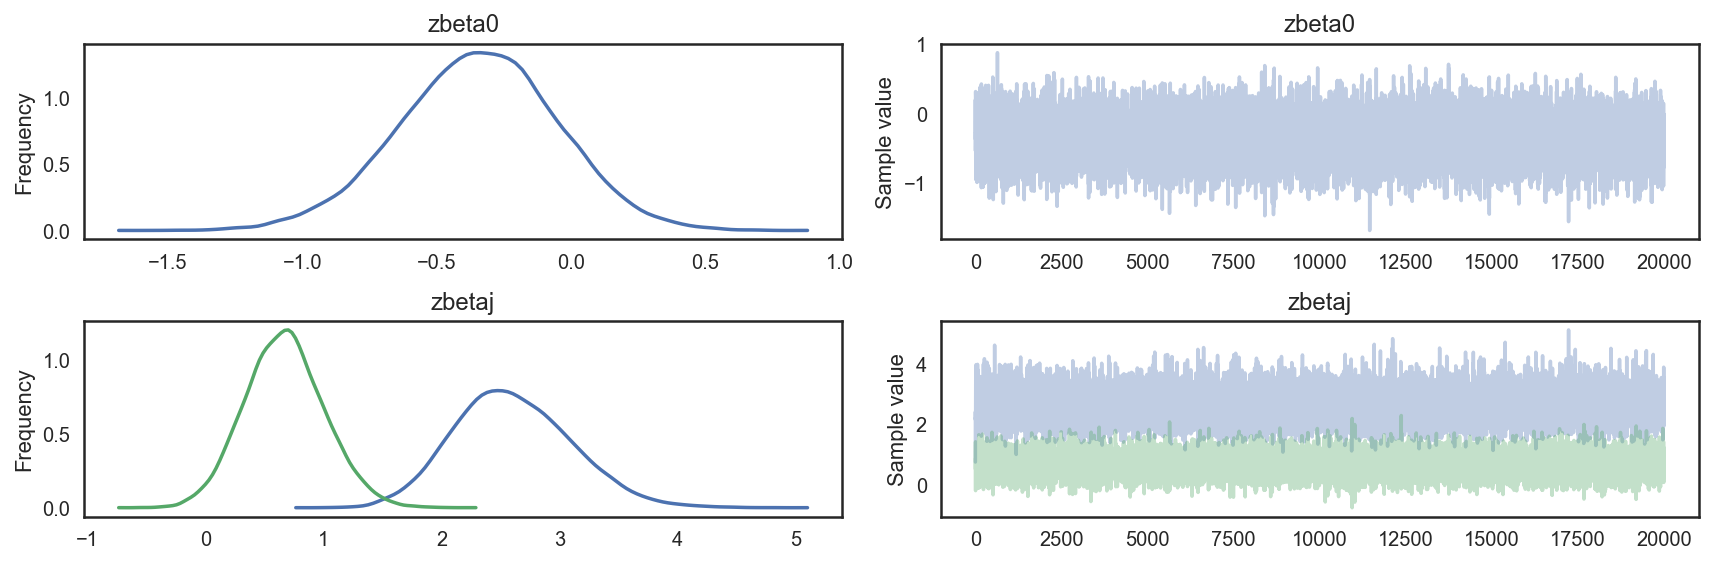

In [12]:
pmc.traceplot(trace2);

#### Figure 21.4

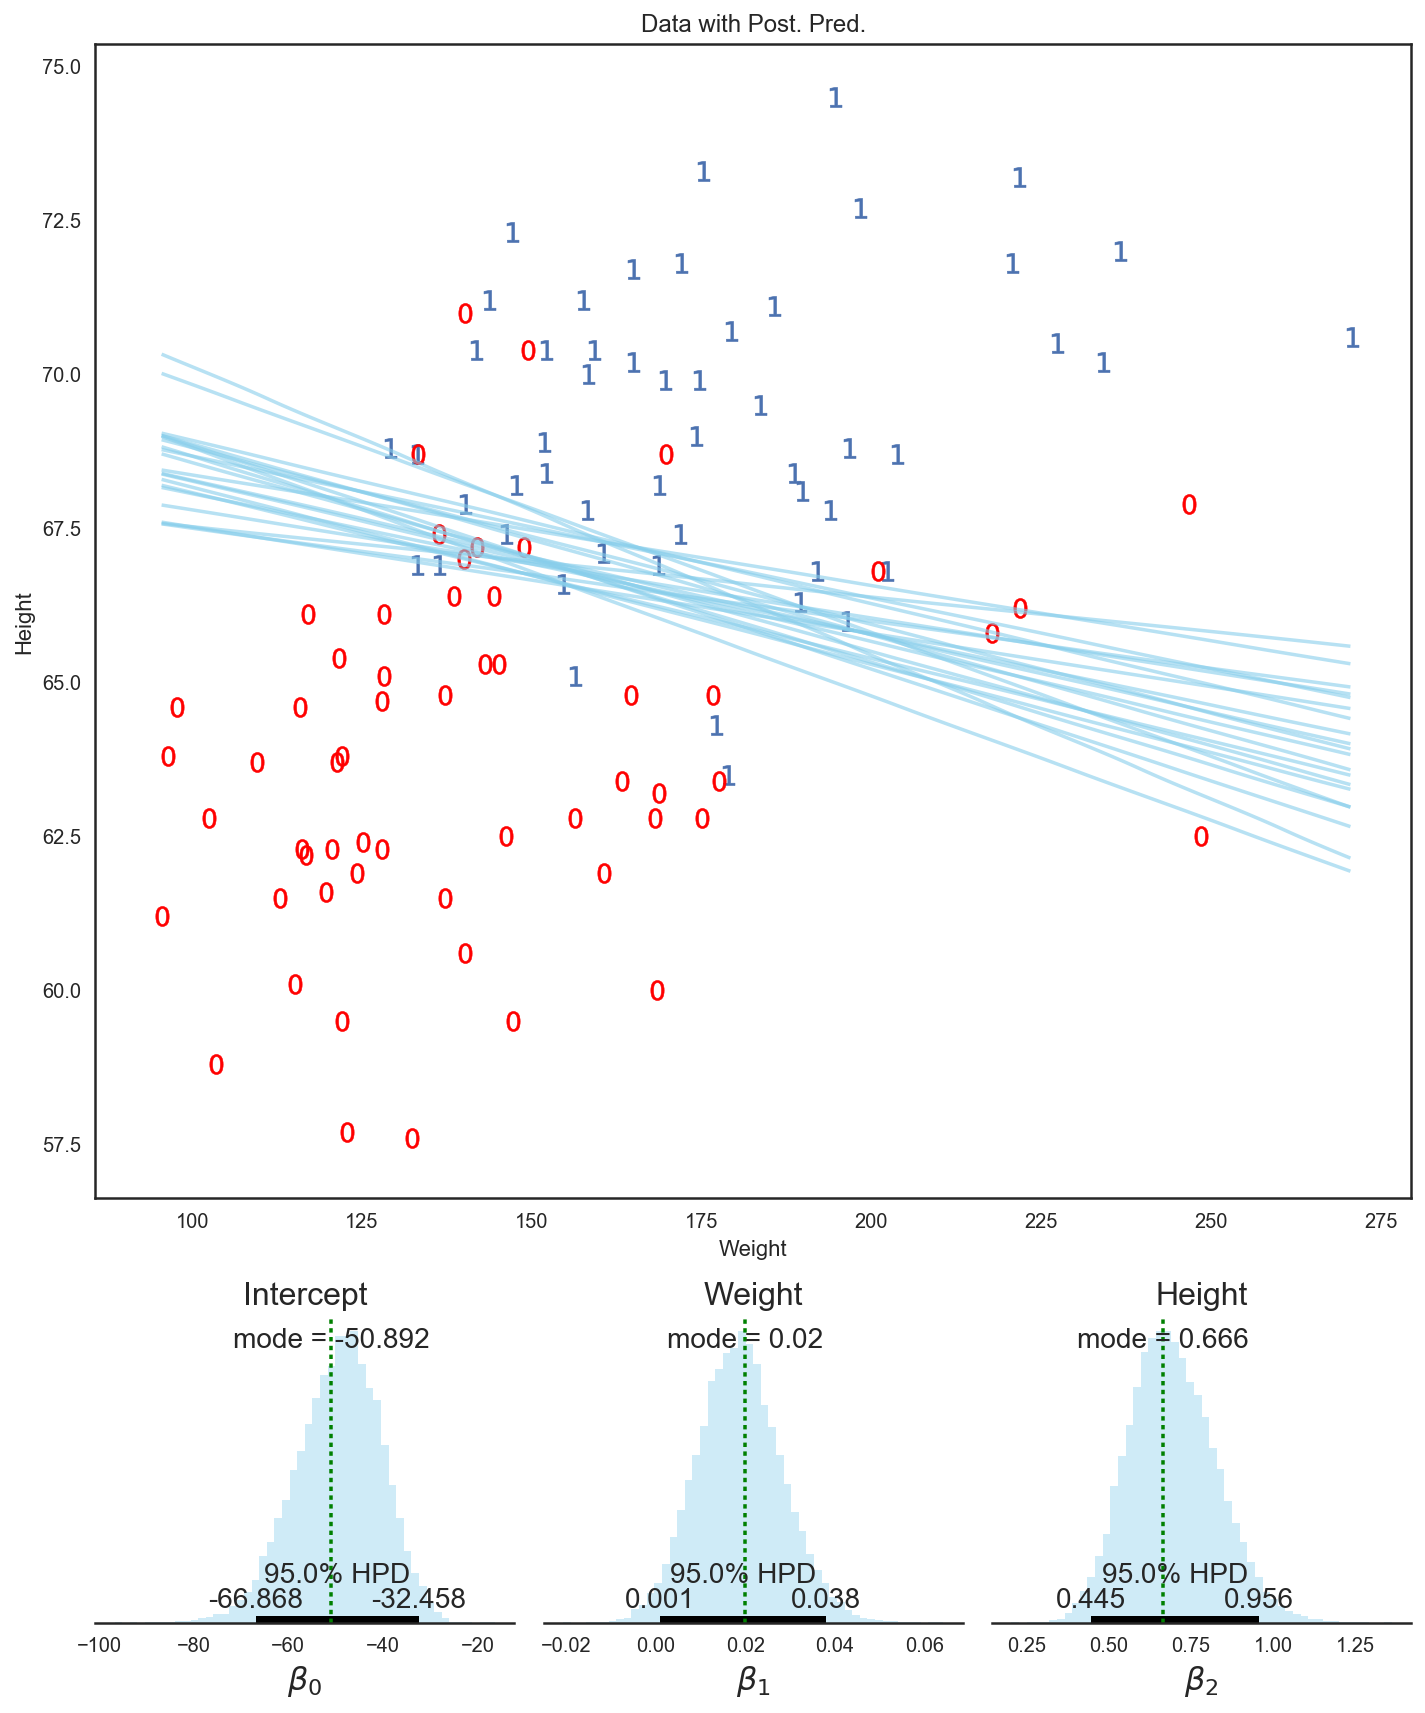

In [13]:
# Transform parameters back to original scale
beta0 = trace2['zbeta0'] - np.sum(trace2['zbetaj']*meanx/scalex, axis=1)
betaj = (trace2['zbetaj']/scalex)

plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 3)
ax1 = plt.subplot(gs[:3,:3])
ax2 = plt.subplot(gs[3,0])
ax3 = plt.subplot(gs[3,1])
ax4 = plt.subplot(gs[3,2])

mask = df.male == 1
ax1.scatter(df[mask].weight, df[mask].height, s=100, marker='$1$',)
ax1.scatter(df[~mask].weight, df[~mask].height, s=100, c='r', marker='$0$')
ax1.set_xlabel('Weight')
ax1.set_ylabel('Height')
ax1.set_title('Data with Post. Pred.')

# Take 20 values from the posterior distribution and plot the lines
tr_len = len(trace2)
n_curves = 20
stepIdxVec = np.arange(500, tr_len, tr_len//n_curves)
weight_span = np.arange(df.weight.min(), df.weight.max())
height_span = np.arange(df.height.min(), df.height.max())

# Prepare grid for contour plot
xx, yy = np.meshgrid(height_span, weight_span, indexing='xy')
Z = np.zeros((weight_span.size,height_span.size))
# Calculate p based on grid of weights and heights
# ToDo: remove nested loop
for idx in stepIdxVec:
    for (i,j),v in np.ndenumerate(Z):
        Z[i,j] = expit(beta0[idx] + betaj[idx,0]*xx[i,j] + betaj[idx,1]*yy[i,j])
    CS = ax1.contour(yy, xx, Z, colors=color, alpha=0.6, levels=[0.5])

plot_posterior(beta0, ax=ax2)
ax2.set_title('Intercept', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)

plot_posterior(betaj[:,1], ax=ax3)
ax3.set_title('Weight', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict)

plot_posterior(betaj[:,0], ax=ax4)
ax4.set_title('Height', fontdict=f_dict)
ax4.set_xlabel(r'$\beta_2$', fontdict=f_dict);

plt.tight_layout();

### 21.3 - Robust Logistic Regression

#### Predicting gender from weight alone (robust)

In [38]:
with pmc.Model() as model_weight_robust:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=2)
    
    guess = pmc.Beta('guess', alpha=1, beta=9)
    
    p = (guess*(1/2) + (1.0-guess)*pmc.invlogit(zbeta0 + zbetaj*zX[:,1]))
        
    likelihood = pmc.Bernoulli('likelihood', p, observed=y.values)

Applied logodds-transform to guess and added transformed guess_logodds_ to model.


In [39]:
with model_weight_robust:
    trace3 = pmc.sample(20000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned NUTS to guess_logodds_
 [-----------------100%-----------------] 20000 of 20000 complete in 31.5 sec

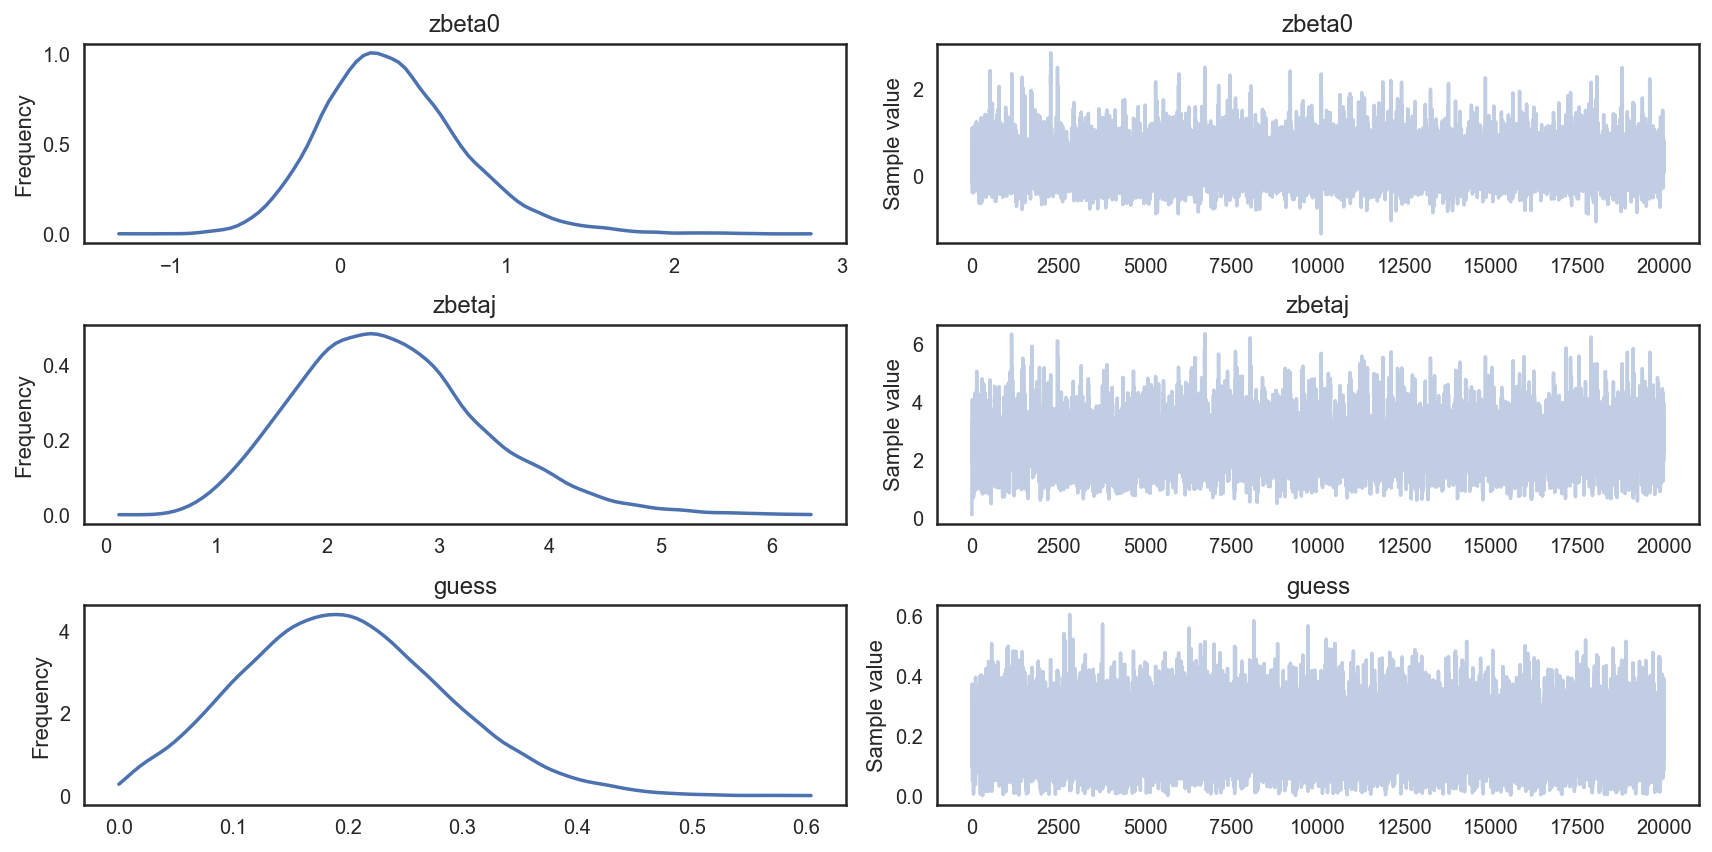

In [40]:
pmc.traceplot(trace3);

#### Figure 21.8

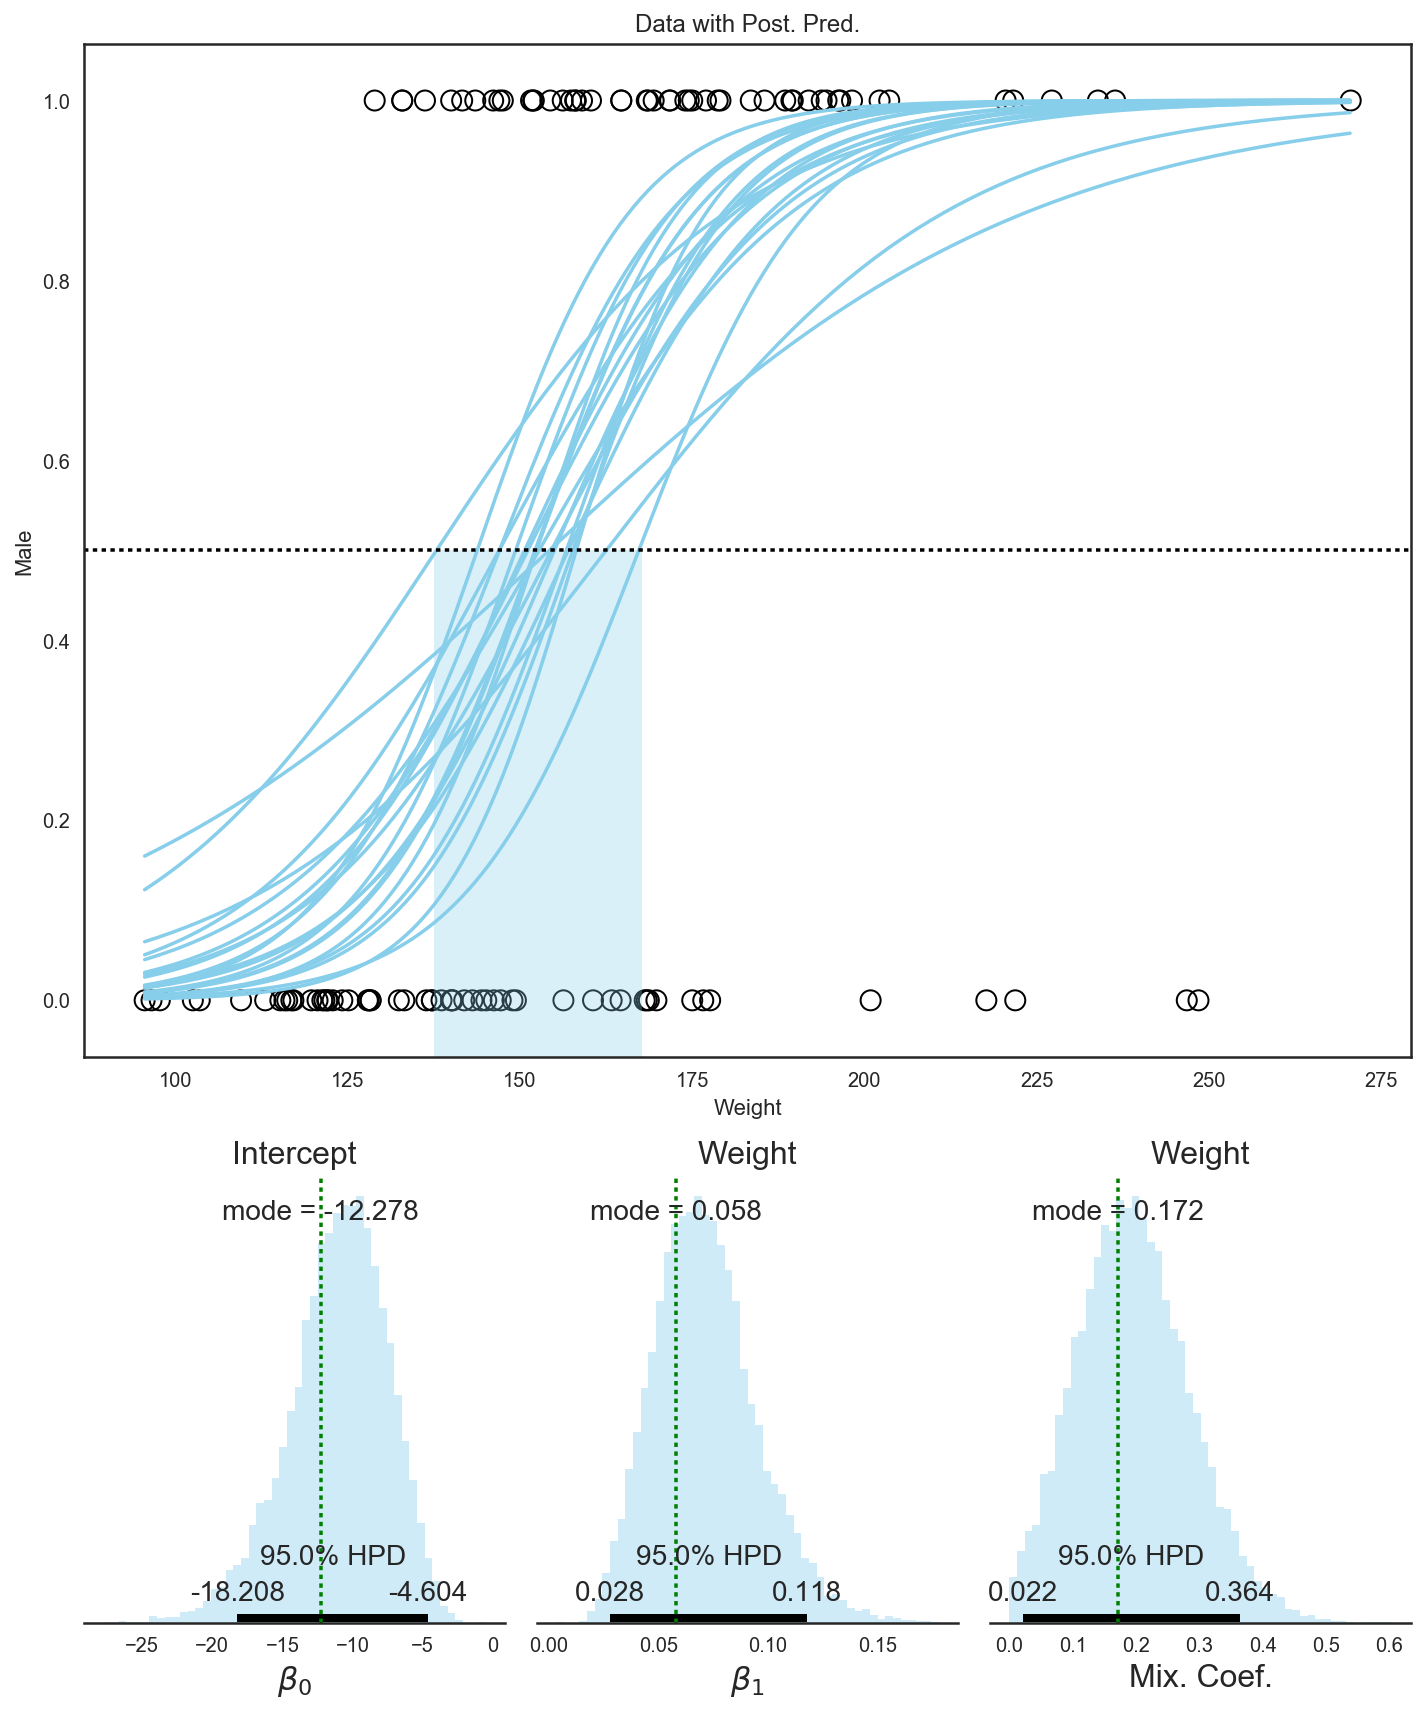

In [41]:
# Transform parameters back to original scale
beta0 = trace3['zbeta0'] - trace3['zbetaj']*meanx[1]/scalex[1]
betaj = (trace3['zbetaj']/scalex[1])

plt.figure(figsize=(10,12))
# Define gridspec
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[:2,:3])
ax2 = plt.subplot(gs[2,0])
ax3 = plt.subplot(gs[2,1])
ax4 = plt.subplot(gs[2,2])

ax1.scatter(df.weight, df.male, s=100, edgecolor='k', facecolors='None', lw=1)

# Take 20 values from the posterior distribution and plot the lines
n_curves = 20
tr_len = len(trace3)
stepIdxVec = np.arange(250, tr_len, tr_len//n_curves)
weight_span = np.arange(df.weight.min(), df.weight.max())
weights = np.tile(weight_span.reshape(-1,1), (1,n_curves))
# The expit function from scipy.special calculates the inverse of the logit function
p = expit(beta0[stepIdxVec] + betaj[stepIdxVec]*weights)
ax1.plot(weights, p, c=color)

ax1.axhline(y=0.5, color='k', linestyle='dotted')

# Look up weights for which of the posterior probabilities is (close to) 0.5
decision_boundary = weight_span[np.any(np.isclose(p, 0.5, atol=0.01), axis=1)]
# Highlight the weightspan
ax1.axvspan(decision_boundary.min(), decision_boundary.max(),
            0, 0.5, color=color, alpha=0.3)

ax1.set_xlabel('Weight')
ax1.set_ylabel('Male')
ax1.set_title('Data with Post. Pred.')

plot_posterior(beta0, ax=ax2)
ax2.set_title('Intercept', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)

plot_posterior(betaj, ax=ax3)
ax3.set_title('Weight', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict);

plot_posterior(trace3['guess'], ax=ax4)
ax4.set_title('Weight', fontdict=f_dict)
ax4.set_xlabel('Mix. Coef.', fontdict=f_dict);

plt.tight_layout();

### 21.4 - Nominal Predictors
#### 21.4.2 - Multiple groups

#### Data 
See also section 9.5.1

In [110]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3], dtype={'PriPos':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
Player    948 non-null object
PriPos    948 non-null category
Hits      948 non-null int64
AtBats    948 non-null int64
dtypes: category(1), int64(2), object(1)
memory usage: 23.3+ KB


In [118]:
df2.sort_values('PriPos', inplace=True)
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.head()

            Player    PriPos  Hits  AtBats     BatAv
61   Lance Berkman  1st Base    21      81  0.259259
736  Mark Reynolds  1st Base   101     457  0.221007
696     Brett Pill  1st Base    22     105  0.209524
576  Casey McGehee  1st Base    69     318  0.216981
177   David Cooper  1st Base    42     140  0.300000

#### Model (Kruschke, 2015)

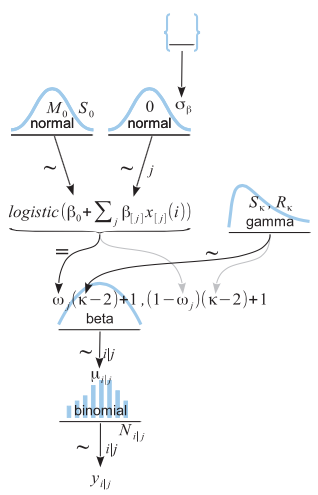

In [59]:
Image('images/fig21_12.png')

In [169]:
# Encode the 9 primary field positions
le = preprocessing.LabelEncoder()
pripos_idx = le.fit_transform(df2.PriPos)
pripos_codes = le.classes_
n_pripos = len(le.classes_)

# df2 contains one entry per player
n_players = df2.index.size

with pmc.Model() as hierarchical_model:
    # Hyper parameters
    aSigma = pmc.Gamma('aSigma', 1.64, 0.32)
    a0 = pmc.Normal('a0', 0.0, tau=1/2**2)
    a = pmc.Normal('a', 0.0, tau=1/aSigma**2, shape=n_pripos) 
    
    # Parameters for categories (Primary field positions)
    omega = pmc.Deterministic('omega', pmc.invlogit(a0 + a))
    kappa = pmc.Gamma('kappa', 0.01, 0.01)
    
    # Parameter for individual players
    mu = pmc.Beta('mu',
                  omega[pripos_idx]*kappa+1, (1-omega[pripos_idx])*kappa+1,
                  shape = n_players)
    
    y = pmc.Binomial('y', n=df2.AtBats.as_matrix(), p=mu, observed=df2.Hits.as_matrix())
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pmc.Deterministic('m', a0 + a)
    b0 = pmc.Deterministic('b0', tt.mean(m))
    b = pmc.Deterministic('b', m - b0) 

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied log-transform to kappa and added transformed kappa_log_ to model.
Applied logodds-transform to mu and added transformed mu_logodds_ to model.


In [175]:
with hierarchical_model:
    trace4 = pmc.sample(1000)

Assigned NUTS to aSigma_log_
Assigned NUTS to a0
Assigned NUTS to a
Assigned NUTS to kappa_log_
Assigned NUTS to mu_logodds_
 [-----------------100%-----------------] 1001 of 1000 complete in 437.6 sec

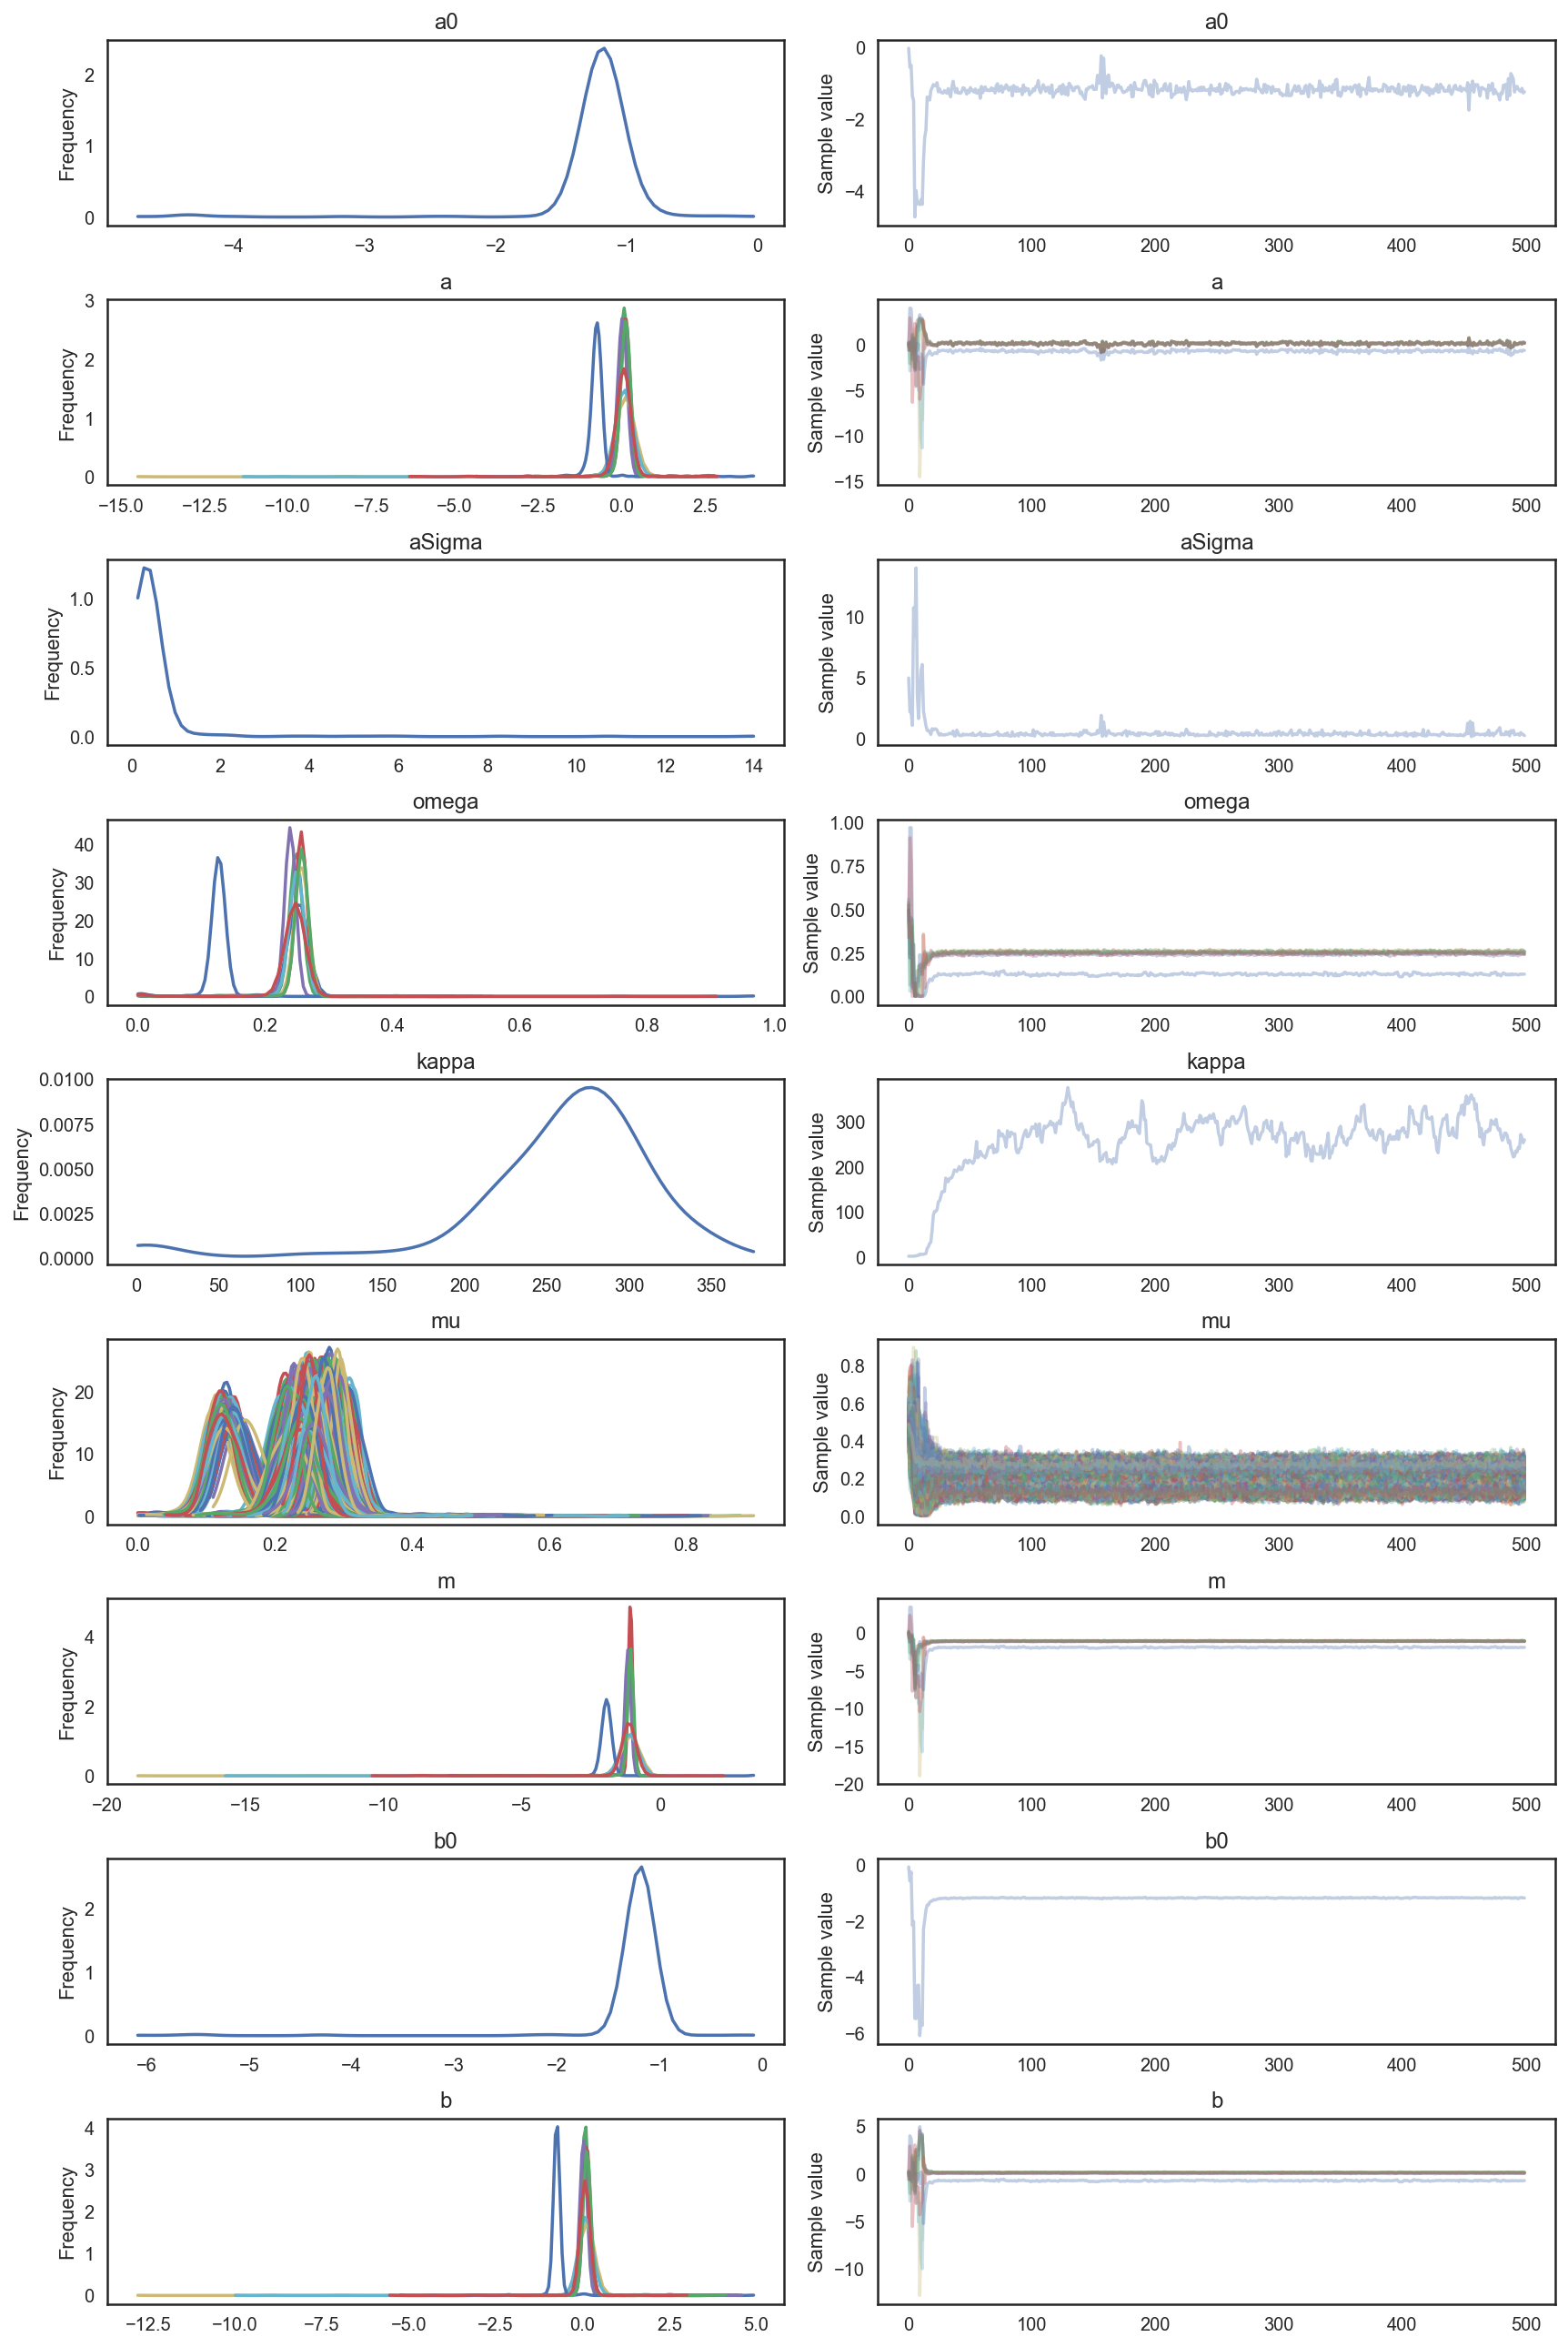

In [171]:
pmc.traceplot(trace4);

In [181]:
trace4['omega'][:,0]

(1000,)

In [177]:
pmc.df_summary(trace4)

                mean         sd  mc_error     hpd_2.5    hpd_97.5
a0         -1.195699   0.199686  0.008845   -1.450930   -0.913732
a__0        0.102867   0.152627  0.005724   -0.181985    0.376147
a__1        0.086671   0.155143  0.005638   -0.184967    0.355895
a__2        0.126215   0.148214  0.005373   -0.151671    0.390884
a__3        0.029798   0.155464  0.005125   -0.221949    0.317946
a__4        0.132269   0.184443  0.007320   -0.146021    0.422107
a__5        0.091898   0.158517  0.005726   -0.182378    0.362263
a__6       -0.736593   0.156332  0.005892   -1.026549   -0.439879
a__7        0.129114   0.153301  0.004926   -0.138442    0.423306
a__8        0.076021   0.174950  0.005437   -0.183984    0.365869
aSigma      0.371768   0.188877  0.012763    0.174353    0.615051
omega__0    0.251718   0.015690  0.000391    0.242034    0.260591
omega__1    0.248528   0.015119  0.000478    0.238733    0.258939
omega__2    0.256106   0.013834  0.000584    0.246378    0.265921
omega__3  

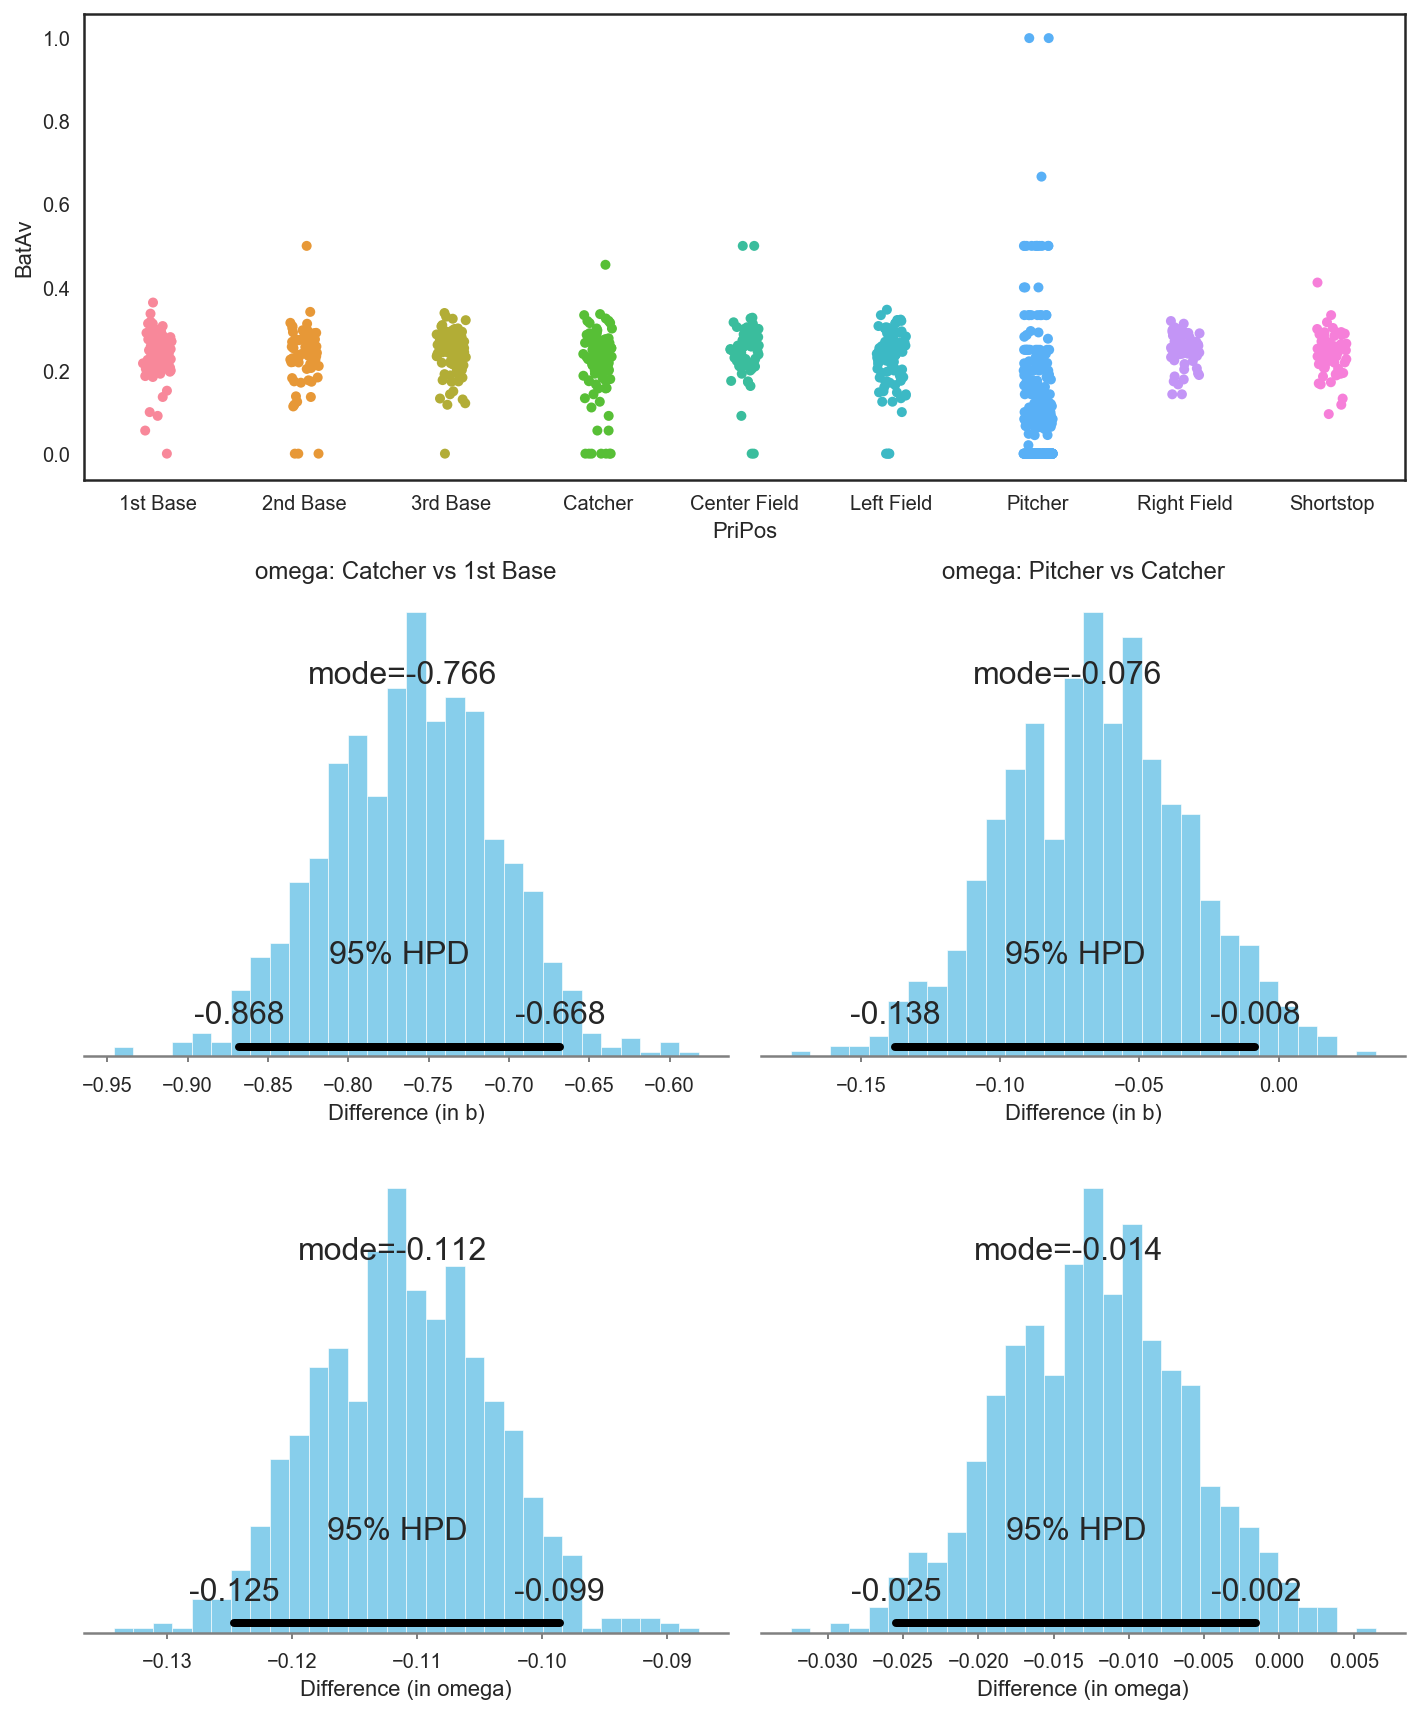

In [182]:
plt.figure(figsize=(10,12))
# Define gridspec
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

burnin = 100

sns.stripplot(x='PriPos', y='BatAv', data=df2, jitter=True, ax=ax1)    

pmc.plot_posterior(trace4['b'][burnin:,6]-trace4['b'][burnin:,3], ax=ax2, point_estimate='mode', color=color)
ax2.set_title('b: Pitcher vs Catcher')
pmc.plot_posterior(trace4['b'][burnin:,3]-trace4['b'][burnin:,0], ax=ax3, point_estimate='mode', color=color)
ax3.set_title('b: Catcher vs 1st Base')
for ax in [ax2, ax3]:
    ax.set_xlabel('Difference (in b)')

pmc.plot_posterior(trace4['omega'][burnin:,6]-trace4['omega'][burnin:,3], ax=ax4, point_estimate='mode', color=color)
ax3.set_title('omega: Pitcher vs Catcher')
pmc.plot_posterior(trace4['omega'][burnin:,3]-trace4['omega'][burnin:,0], ax=ax5, point_estimate='mode', color=color)
ax2.set_title('omega: Catcher vs 1st Base')
for ax in [ax4, ax5]:
    ax.set_xlabel('Difference (in omega)')

plt.tight_layout();